# Hierarchical Clustering

El Clustering Jerárquico es un método de agrupamiento que construye una jerarquía de clusters de manera aglomerativa (desde puntos individuales hasta un único cluster) o divisiva (desde un único cluster hasta puntos individuales). En esta implementación, nos enfocaremos en el método aglomerativo.

### Métodos de Enlace Comunes

- **Single Linkage (Enlace Simple):** La distancia entre dos clusters es la mínima distancia entre cualquier par de puntos en los dos clusters.
- **Complete Linkage (Enlace Completo):** La distancia entre dos clusters es la máxima distancia entre cualquier par de puntos en los dos clusters.
- **Average Linkage (Enlace Promedio):** La distancia entre dos clusters es el promedio de todas las distancias entre pares de puntos en los dos clusters.
- **Centroid Linkage (Enlace de Centroides):** La distancia entre dos clusters es la distancia entre los centroides de los dos clusters.

## 1. Preparación de los Datos

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configuración de estilos de visualización
sns.set(style="whitegrid")
%matplotlib inline

# Carga del dataset (ya limpio de valores faltantes)
df = pd.read_csv('movie_data.csv', sep=';').dropna()

# Tomar una muestra del 10% del dataset
df_sample = df.sample(frac=0.007, random_state=42)

# Selección de dos características para visualización en 2D
numerical_features_sample = ['budget', 'popularity']
X_sample = df_sample[numerical_features_sample].values

# Escalado de las variables
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(X_sample)

## 2. Implementación del Algoritmo de Clustering Jerárquico desde Cero

Primero, implementaremos una clase `HierarchicalClusteringFromScratch` que maneje el proceso de clustering jerárquico.

In [11]:
def hierarchical_clustering(X, linkage='single'):
    n_samples = X.shape[0]
    clusters = [[i] for i in range(n_samples)]
    cluster_labels = [i for i in range(n_samples)]
    distances = np.sqrt(((X[:, np.newaxis] - X[np.newaxis, :]) ** 2).sum(axis=2))
    np.fill_diagonal(distances, np.inf)
    Z = []
    distance_matrices = [distances.copy()]
    
    for step in range(n_samples - 1):
        # Encontrar el par con la distancia mínima
        idx = np.argmin(distances)
        i, j = np.unravel_index(idx, distances.shape)
        dist = distances[i, j]
        
        # Registrar la unión
        c1_label = cluster_labels[i]
        c2_label = cluster_labels[j]
        Z.append([c1_label, c2_label, dist, len(clusters[i]) + len(clusters[j])])
        
        # Fusionar clusters
        new_cluster = clusters[i] + clusters[j]
        new_label = n_samples + step
        clusters.append(new_cluster)
        cluster_labels.append(new_label)
        
        # Eliminar los clusters antiguos
        # Eliminar en orden inverso para evitar el desplazamiento de índices
        for index in sorted([i, j], reverse=True):
            del clusters[index]
            del cluster_labels[index]
        
        # Actualizar la matriz de distancias
        distances = np.delete(distances, [i, j], axis=0)
        distances = np.delete(distances, [i, j], axis=1)
        
        # Calcular distancias entre el nuevo cluster y los clusters restantes
        new_dist_row = []
        for k in range(len(clusters) - 1):  # Excluir el nuevo cluster mismo
            if linkage == 'single':
                d = min([np.linalg.norm(X[p1] - X[p2]) for p1 in new_cluster for p2 in clusters[k]])
            elif linkage == 'complete':
                d = max([np.linalg.norm(X[p1] - X[p2]) for p1 in new_cluster for p2 in clusters[k]])
            elif linkage == 'average':
                dists = [np.linalg.norm(X[p1] - X[p2]) for p1 in new_cluster for p2 in clusters[k]]
                d = sum(dists) / len(dists)
            elif linkage == 'centroid':
                centroid_new = np.mean(X[new_cluster], axis=0)
                centroid_k = np.mean(X[clusters[k]], axis=0)
                d = np.linalg.norm(centroid_new - centroid_k)
            new_dist_row.append(d)
        new_dist_row.append(np.inf)  # Distancia del nuevo cluster a sí mismo es infinito
        new_dist_row = np.array(new_dist_row)
        
        # Añadir la nueva fila y columna a la matriz de distancias
        distances = np.vstack([distances, new_dist_row[:-1]])
        new_dist_col = np.append(new_dist_row[:-1], np.inf).reshape(-1, 1)
        distances = np.hstack([distances, new_dist_col])
        
        # Añadir la matriz de distancias actualizada a la lista
        distance_matrices.append(distances.copy())
        
    return np.array(Z), distance_matrices

## 3. Generación de las Visualizaciones Solicitadas

### 3.1. GIF de la Evolución de la Matriz de Distancias

Crearemos un GIF que muestra cómo evoluciona la matriz de distancias durante cada iteración del algoritmo.

In [12]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_distance_matrix(distance_matrices):
    fig, ax = plt.subplots()
    
    def update(frame):
        ax.clear()
        im = ax.imshow(distance_matrices[frame], cmap='viridis')
        ax.set_title(f'Matriz de Distancias - Iteración {frame}')
        return [im]
    
    ani = animation.FuncAnimation(fig, update, frames=len(distance_matrices), blit=True)
    ani.save('hc_outputs/distance_matrix_evolution.gif', writer='pillow')
    plt.close()

# Ejecutar el clustering y obtener las matrices de distancia
Z, distance_matrices = hierarchical_clustering(X_scaled_sample, linkage='single')

# Generar el GIF
animate_distance_matrix(distance_matrices)

### 3.2. Generar Dendrogramas

Utilizaremos la matriz de enlace `Z` para generar el dendrograma.

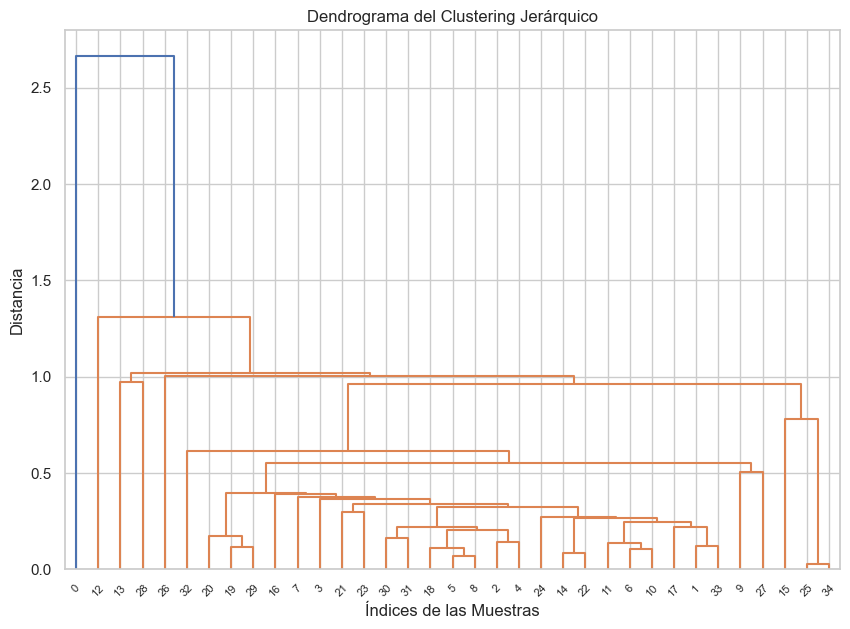

In [13]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(Z):
    plt.figure(figsize=(10, 7))
    dendrogram(Z.astype(float))
    plt.title('Dendrograma del Clustering Jerárquico')
    plt.xlabel('Índices de las Muestras')
    plt.ylabel('Distancia')
    plt.show()

plot_dendrogram(Z)

### 3.3. GIF con Dendrograma y Clusters Cambiantes según el Threshold

Crearemos un GIF que muestra cómo cambian los clusters al variar el threshold en el dendrograma.

In [14]:
def animate_dendrogram_threshold(Z, X):
    from scipy.cluster.hierarchy import dendrogram, fcluster
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    thresholds = np.linspace(np.max(Z[:, 2]), 0, num=20)
    
    # Reducir a 2D si es necesario
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X)
    else:
        X_vis = X
    
    def update(frame):
        thresh = thresholds[frame]
        ax1.clear()
        dendrogram(Z, color_threshold=thresh, ax=ax1, no_labels=True)
        ax1.axhline(y=thresh, c='k', linestyle='--')
        ax1.set_title(f'Dendrograma (Threshold = {thresh:.2f})')

        clusters = fcluster(Z, thresh, criterion='distance')
        ax2.clear()
        sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=clusters, palette='tab10', ax=ax2, legend=False)
        ax2.set_title('Clusters en 2D')

    ani = animation.FuncAnimation(fig, update, frames=len(thresholds), blit=False)
    ani.save('hc_outputs/dendrogram_threshold.gif', writer='pillow')
    plt.close()


from scipy.cluster.hierarchy import fcluster

animate_dendrogram_threshold(Z, X_scaled_sample)

### 3.4. GIF que Ilustra la Fusión de Clusters

Este GIF mostrará cómo se van fusionando los clusters en cada iteración.

In [15]:
def animate_cluster_merging(Z, X):
    fig, ax = plt.subplots(figsize=(10, 7))

    # Inicialmente, cada punto es un cluster
    clusters = np.arange(X.shape[0])
    
    # Reducir a 2D si es necesario
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X)
    else:
        X_vis = X
    
    frames = []
    cluster_history = [clusters.copy()]
    
    # Generar la historia de clusters
    for i in range(Z.shape[0]):
        cluster1, cluster2 = int(Z[i, 0]), int(Z[i, 1])
        clusters[clusters == cluster2] = cluster1
        cluster_history.append(clusters.copy())
    
    def update(frame):
        ax.clear()
        sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=cluster_history[frame], palette='tab10', ax=ax, legend=False)
        ax.set_title(f'Fusión de Clusters - Iteración {frame}')
    
    ani = animation.FuncAnimation(fig, update, frames=len(cluster_history), blit=False)
    ani.save('hc_outputs/cluster_merging.gif', writer='pillow')
    plt.close()

animate_cluster_merging(Z, X_scaled_sample)


### 3.5. Creación de Dendrogramas Interactivos

Utilizaremos Plotly para crear un dendrograma interactivo.

In [16]:
import plotly.figure_factory as ff

def interactive_dendrogram(Z):
    fig = ff.create_dendrogram(X_scaled_sample, linkagefun=lambda x: Z)
    fig.update_layout(width=800, height=500)
    fig.show()

interactive_dendrogram(Z)

### 3.6. Loop sobre Pares de Columnas Numéricas

Implementaremos un bucle que itera sobre todos los pares únicos de columnas numéricas y genera los dendrogramas y visualizaciones correspondientes.

In [17]:
from itertools import combinations

numerical_features_full = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

for feature_pair in combinations(numerical_features_full, 2):
    X_pair = df_sample[list(feature_pair)].values
    X_scaled_pair = scaler.fit_transform(X_pair)

    Z_pair, _ = hierarchical_clustering(X_scaled_pair, linkage='single')

    # Generar y guardar el dendrograma
    plt.figure(figsize=(10, 7))
    dendrogram(Z_pair.astype(float))
    plt.title(f'Dendrograma para {feature_pair[0]} y {feature_pair[1]}')
    plt.xlabel('Índices de las Muestras')
    plt.ylabel('Distancia')
    plt.savefig(f'hc_outputs/dendrogram_{feature_pair[0]}_{feature_pair[1]}.png')
    plt.close()